In [1]:
import torch
from torch import nn

from loft_optim.optimizer import AdamW, LoFTAdamW
from loft_optim.optim_helper import (rescale_gradients,
                                     compute_mom_sq_from_row_prod_and_transformation,
                                     compute_full_grad_from_proj, compute_proj_update)

In [2]:
# Adam vs. LoFT-Adam on matrix factorization

class MatrixFactorization(torch.nn.Module):
    def __init__(self, m, n, r):
        super(MatrixFactorization, self).__init__()
        self.lora_A = nn.Linear(m, r, bias=False)
        self.lora_B = nn.Linear(r, n, bias=True)

    def forward(self, input):
        return self.lora_B(self.lora_A(input))

class LinearModel(nn.Module):
    def __init__(self, m, n):
        super(LinearModel, self).__init__()
        self.W = nn.Linear(m, n, bias=True)

    def forward(self, input):
        return self.W(input)




In [3]:
# sanity check, i.e., we should recover full Adam if rank is r = min{m,n}

from copy import deepcopy

device = torch.device("cuda")

# optimize with AdamW 
m = 13
n = 13
r = 13

n_steps = 20
eps = 1e-2

# set seed
torch.manual_seed(42)
A = torch.randn(m, r).to(device)
B = torch.randn(r, n).to(device)
W = A @ B

# matrix factorization
# baseline our AdamW vs AdamW
lr = 1e-1
network_factorized = MatrixFactorization(m, n, r).to(device)
optimizer_factorized =  LoFTAdamW(network_factorized.parameters(), lr=lr, weight_decay=0., model=network_factorized, betas=(0., 0.), eps=eps)
network_full = LinearModel(m, n).to(device)
optimizer_full = AdamW(network_full.parameters(), lr=lr, weight_decay=0., betas=(0., 0.), eps=eps)
# assure weights are the same
network_full.W.weight.data = torch.clone(network_factorized.lora_B.weight.data @ network_factorized.lora_A.weight.data)
network_full.W.bias.data = network_factorized.lora_B.bias.data.clone()

loss_fn = torch.nn.MSELoss()

losses_factorized = []
losses_full = []

# print difference between model
print(f"Step {0:3d}: ")
print(f"    bias_diff: {torch.norm(network_full.W.bias - network_factorized.lora_B.bias).item()}")
print(f"    weight_diff: {torch.norm(network_full.W.weight - network_factorized.lora_B.weight @ network_factorized.lora_A.weight).item()}")
print("-----------------------------")

max_deviation = 0

for i in range(n_steps):
    input = torch.eye(m).to(device)
    
    optimizer_factorized.zero_grad()
    pred = network_factorized(input)
    loss = loss_fn(pred, input @ W)
    loss.backward()
    losses_factorized.append(loss.item())

    optimizer_full.zero_grad()
    pred = network_full(input)
    loss = loss_fn(pred, input @ W)
    loss.backward()
    losses_full.append(loss.item())

    full_grad = network_full.W.weight.grad
    mom_sq = full_grad**2
    update = full_grad / (mom_sq.sqrt() + eps)

    partial_grad_A = network_factorized.lora_A.weight.grad
    partial_grad_B = network_factorized.lora_B.weight.grad

    lora_A = True
    other_p = network_factorized.lora_B.weight
    grad, scaling = rescale_gradients(partial_grad_A, other_p, lora_A)
    full_grad_A = compute_full_grad_from_proj(grad, other_p, lora_A)
    vec = grad.T if lora_A else grad
    row_prod = torch.bmm(vec[:, :, None], vec[:, None, :])
    mom_sq_A = compute_mom_sq_from_row_prod_and_transformation(row_prod, other_p.T if lora_A else other_p).T
    update_A = full_grad_A / (mom_sq_A.sqrt() + eps)
    update_A = compute_proj_update(update_A, scaling, other_p, lora_A)
    update_A = compute_full_grad_from_proj(update_A, other_p, lora_A)
   

    print("LoRA A")
    print(f"Grad Difference relative: {(full_grad - full_grad_A).norm(2).item() / full_grad.norm(2).item()}")
    print(f"Moment Difference relative: {(mom_sq - mom_sq_A).norm(2).item() / mom_sq.norm(2).item()}")
    print(f"Update Difference relative: {(update - update_A).norm(2).item() / update.norm(2).item()}")
    print("-----------------------------")

    lora_A = False
    other_p = network_factorized.lora_A.weight
    grad, scaling = rescale_gradients(partial_grad_B, other_p, lora_A)
    full_grad_B = compute_full_grad_from_proj(grad, other_p, lora_A)
    vec = grad.T if lora_A else grad
    row_prod = torch.bmm(vec[:, :, None], vec[:, None, :])
    mom_sq_B = compute_mom_sq_from_row_prod_and_transformation(row_prod, other_p)
    update_B = full_grad_B / (mom_sq_B.sqrt() + eps)
    update_B = compute_proj_update(update_B, scaling, other_p, lora_A)
    update_B = compute_full_grad_from_proj(update_B, other_p, lora_A)

    print("LoRA B")
    print(f"Grad Difference relative: {(full_grad - full_grad_B).norm(2).item() / full_grad.norm(2).item()}")
    print(f"Moment Difference relative: {(mom_sq - mom_sq_B).norm(2).item()/ mom_sq.norm(2).item()}")
    print(f"Update Difference relative: {(update - update_B).norm(2).item() / update.norm(2).item()}")
    print("-----------------------------")

    if (mom_sq_A == 0).any() or (mom_sq_B == 0).any():
        print("Zero moment detected")
        if (mom_sq_A == 0).any():
            print("A")
            # find i, j such that mom_sq_A[i, j] == 0
            x, y = torch.nonzero(mom_sq_A == 0, as_tuple=True)
            for j, k in zip(x, y):
                deviation = full_grad_A[j, k].item() / eps
                print(f"Deviation {deviation}")
                if deviation > max_deviation:
                    max_deviation = deviation
        else:
            print("B")
            x, y = torch.nonzero(mom_sq_B == 0, as_tuple=True)
            for j, k in zip(x, y):
                deviation = full_grad_B[j, k].item() / eps
                print(f"Deviation {deviation}")
                if deviation > max_deviation:
                    max_deviation = deviation
        print("-----------------------------")

    optimizer_factorized.step()
    optimizer_full.step()
    # print difference between model
    print(f"Step {i:3d}: ")
    print(f"    bias_diff: {torch.norm(network_full.W.bias - network_factorized.lora_B.bias).item()}")
    print(f"    weight_diff: {torch.norm(network_full.W.weight - network_factorized.lora_B.weight @ network_factorized.lora_A.weight).item()}")
    print("-----------------------------")

print(f"Max deviation: {max_deviation}")


Step   0: 
    bias_diff: 0.0
    weight_diff: 0.0
-----------------------------
LoRA A
Grad Difference relative: 8.009512777627594e-05
Moment Difference relative: 9.190735598718235e-05
Update Difference relative: 0.00020326993836539814
-----------------------------
LoRA B
Grad Difference relative: 3.3706207837619916e-05
Moment Difference relative: 4.265394560911685e-05
Update Difference relative: 7.581020873982333e-05
-----------------------------
Step   0: 
    bias_diff: 0.0
    weight_diff: 6.34411335340701e-05
-----------------------------
LoRA A
Grad Difference relative: 4.595616866837162e-05
Moment Difference relative: 6.194265393636446e-05
Update Difference relative: 0.00010256454932165169
-----------------------------
LoRA B
Grad Difference relative: 3.432207162843878e-05
Moment Difference relative: 3.779843650263763e-05
Update Difference relative: 6.63845968972842e-05
-----------------------------
Step   1: 
    bias_diff: 8.116517733469664e-07
    weight_diff: 0.000101217228

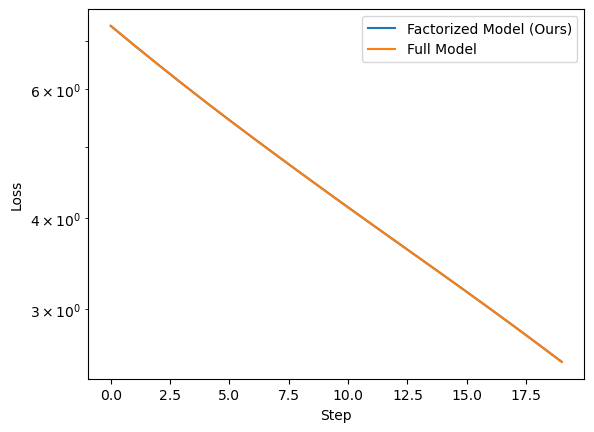

In [4]:
# plot losses
import matplotlib.pyplot as plt

plt.plot(losses_factorized, label="Factorized Model (Ours)")
plt.plot(losses_full, label="Full Model")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [5]:
from copy import deepcopy

device = torch.device("cuda")

# optimize with AdamW 
m = 1024
n = 512
r = 8

n_steps = 300
eps = 1e-4
betas = (0.9, 0.999) # (0., 0.)
lr = 1e1

# set seed
torch.manual_seed(42)
A = torch.randn(m, r).to(device)
B = torch.randn(r, n).to(device)
W = A @ B

# matrix factorization
# baseline our AdamW vs AdamW

network_factorized_ours = MatrixFactorization(m, n, r).to(device)
optimizer_factorized_ours = LoFTAdamW(network_factorized_ours.parameters(), lr=lr, weight_decay=0., model=network_factorized_ours, betas=betas, eps=eps)

network_factorized_no_alt = deepcopy(network_factorized_ours)
optimizer_factorized_no_alt = LoFTAdamW(network_factorized_no_alt.parameters(), lr=lr, weight_decay=0., model=network_factorized_no_alt, betas=betas, eps=eps,
                                              alternate_update=False, rescale_grads=True, reproject_momentum=True, reproject_second_moment=True)

network_factorized_no_proj = deepcopy(network_factorized_ours)
optimizer_factorized_no_proj =  LoFTAdamW(network_factorized_no_proj.parameters(), lr=lr, weight_decay=0., model=network_factorized_no_proj, betas=betas, eps=eps,
                                              alternate_update=True, rescale_grads=True, reproject_momentum=False, reproject_second_moment=False)

network_factorized = deepcopy(network_factorized_ours)
optimizer_factorized =  AdamW(network_factorized.parameters(), lr=lr, weight_decay=0., betas=betas, eps=eps)

network_full = LinearModel(m, n).to(device)
optimizer_full = AdamW(network_full.parameters(), lr=lr, weight_decay=0., betas=betas, eps=eps)
# assure weights are the same
network_full.W.weight.data = torch.clone(network_factorized.lora_B.weight.data @ network_factorized.lora_A.weight.data)
network_full.W.bias.data = network_factorized.lora_B.bias.data.clone()

loss_fn = torch.nn.MSELoss()

losses_factorized_ours = []
losses_factorized_no_alt = []
losses_factorized_no_proj = []
losses_factorized = []
losses_full = []


for i in range(n_steps):
    input = torch.eye(m).to(device)

    optimizer_factorized_ours.zero_grad()
    pred = network_factorized_ours(input)
    loss = loss_fn(pred, input @ W)
    loss.backward()
    losses_factorized_ours.append(loss.item())

    optimizer_factorized_no_alt.zero_grad()
    pred = network_factorized_no_alt(input)
    loss = loss_fn(pred, input @ W)
    loss.backward()
    losses_factorized_no_alt.append(loss.item())

    optimizer_factorized_no_proj.zero_grad()
    pred = network_factorized_no_proj(input)
    loss = loss_fn(pred, input @ W)
    loss.backward()
    losses_factorized_no_proj.append(loss.item())
    
    optimizer_factorized.zero_grad()
    pred = network_factorized(input)
    loss = loss_fn(pred, input @ W)
    loss.backward()
    losses_factorized.append(loss.item())

    optimizer_full.zero_grad()
    pred = network_full(input)
    loss = loss_fn(pred, input @ W)
    loss.backward()
    losses_full.append(loss.item())

    optimizer_factorized_ours.step()
    optimizer_factorized_no_alt.step()
    optimizer_factorized_no_proj.step()
    optimizer_factorized.step()
    optimizer_full.step()



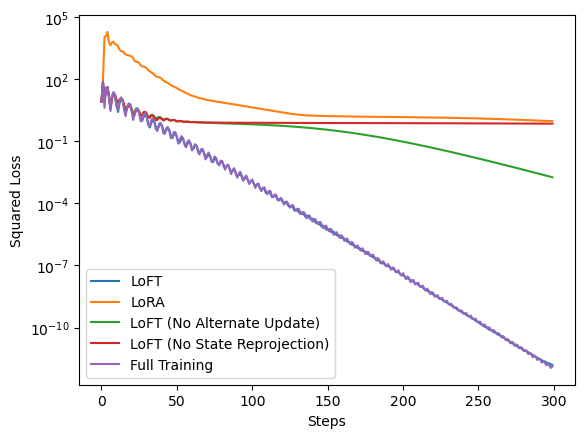

In [6]:
# plot losses
import matplotlib.pyplot as plt

plt.plot(losses_factorized_ours, label="LoFT")
plt.plot(losses_factorized, label="LoRA")
plt.plot(losses_factorized_no_alt, label="LoFT (No Alternate Update)")
plt.plot(losses_factorized_no_proj, label="LoFT (No State Reprojection)")
plt.plot(losses_full, label="Full Training")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Squared Loss")
plt.yscale("log")
plt.show()